# Predicting COVID-19 Cases with RNN LSTM Model

# 1. Data Preprocessing

## 1.1 Import Dependencies

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test_round2.csv
./data/train_round2.csv
./data/graph_round2.csv
./data/test.csv
./data/graph.csv
./data/submission_round2.csv
./data/submission.csv
./data/train.csv


## 1.2 Set Up Dataframes

### 1.2.1 Load Temporal Data

In [3]:
data_dir = 'data'
temporal_data_path = os.path.join(data_dir, 'train_round2.csv')
mobility_data_path = os.path.join(data_dir, 'graph_round2.csv')

temporal_data = pd.read_csv(temporal_data_path)
temporal_data.describe()

,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,11250.000000,1.125000e+04,11250.000000,9419.000000,1.125000e+04,11250.000000,1.055000e+04,5047.000000,10550.000000,11250.000000,5047.000000
mean,5624.500000,9.583625e+04,3057.178311,40276.189086,5.907248e+04,1357.938709,1.161268e+06,6250.044185,3.300561,20085.845676,12.197144
std,3247.739599,1.516621e+05,5377.615328,81746.843553,1.243728e+05,1199.193935,2.031813e+06,13880.694435,2.039538,19319.956138,5.255183
min,0.000000,2.700000e+02,0.000000,0.000000,-9.890000e+02,32.771004,5.459000e+03,10.000000,0.000000,460.300152,2.302896
25%,2812.250000,1.054600e+04,273.000000,3030.500000,4.599500e+03,374.587118,1.579640e+05,595.000000,1.708176,5761.788808,8.387037
50%,5624.500000,4.175800e+04,1031.000000,10376.000000,1.579100e+04,1045.850447,4.901655e+05,2068.000000,2.802207,15172.226199,11.351161
75%,8436.750000,1.174958e+05,3387.000000,48028.000000,5.289675e+04,2046.182244,1.247765e+06,6134.500000,4.425834,27209.961598,15.396088
max,11249.000000,1.153529e+06,34319.000000,913796.000000,1.095798e+06,9537.675412,1.956515e+07,89995.000000,9.741481,134755.702292,38.501190


### 1.2.2 Load Mobility Data

In [4]:
mobility_data = pd.read_csv(mobility_data_path)
mobility_data.describe()

,04-12-2020,04-13-2020,04-14-2020,04-15-2020,04-16-2020,04-17-2020,04-18-2020,04-19-2020,04-20-2020,04-21-2020,...,11-13-2020,11-14-2020,11-15-2020,11-16-2020,11-17-2020,11-18-2020,11-19-2020,11-20-2020,11-21-2020,11-22-2020
count,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,...,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03
mean,1.031167e+04,1.170723e+04,1.151140e+04,1.178438e+04,1.179731e+04,1.230519e+04,1.163154e+04,1.057303e+04,1.205244e+04,1.279990e+04,...,1.647185e+04,1.548423e+04,1.363303e+04,1.425888e+04,1.423726e+04,1.449577e+04,1.500127e+04,1.559040e+04,1.508463e+04,1.366434e+04
std,1.034501e+05,1.168826e+05,1.139024e+05,1.167934e+05,1.169899e+05,1.218210e+05,1.149333e+05,1.045124e+05,1.190462e+05,1.268384e+05,...,1.615988e+05,1.517883e+05,1.341932e+05,1.402128e+05,1.403964e+05,1.429938e+05,1.476646e+05,1.528825e+05,1.469533e+05,1.330026e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.100000e+01,2.400000e+01,2.475000e+01,2.400000e+01,2.400000e+01,2.500000e+01,2.400000e+01,2.300000e+01,2.700000e+01,2.900000e+01,...,3.600000e+01,3.400000e+01,3.000000e+01,3.000000e+01,2.900000e+01,3.000000e+01,3.300000e+01,3.400000e+01,3.700000e+01,3.600000e+01
50%,7.150000e+01,8.100000e+01,7.950000e+01,8.300000e+01,8.300000e+01,8.500000e+01,7.900000e+01,7.600000e+01,8.700000e+01,9.900000e+01,...,1.280000e+02,1.230000e+02,1.110000e+02,1.050000e+02,1.000000e+02,1.080000e+02,1.170000e+02,1.255000e+02,1.370000e+02,1.340000e+02
75%,2.510000e+02,2.880000e+02,3.025000e+02,3.050000e+02,3.070000e+02,3.112500e+02,2.970000e+02,2.682500e+02,3.102500e+02,3.510000e+02,...,5.105000e+02,5.047500e+02,4.412500e+02,4.067500e+02,3.932500e+02,4.122500e+02,4.552500e+02,4.967500e+02,5.825000e+02,5.510000e+02
max,2.865996e+06,3.208712e+06,3.080286e+06,3.198044e+06,3.216221e+06,3.350439e+06,3.152302e+06,2.825683e+06,3.248109e+06,3.475880e+06,...,4.462261e+06,4.190015e+06,3.665221e+06,3.782182e+06,3.809145e+06,3.899828e+06,4.037380e+06,4.234231e+06,4.059547e+06,3.610555e+06


### 1.2.3 Classify Temporal Data by State

In [5]:
states = list(np.unique(temporal_data['Province_State']))
state_cum_temporal_data = dict.fromkeys(states, None)
state_temporal_data = dict.fromkeys(states, None)
state_cum_temporal_scaler = defaultdict(StandardScaler)
state_temporal_scaler = defaultdict(StandardScaler)
dropped_attr = ['Date',
                'Active',
                'ID', 
                'Province_State', 
                'Incident_Rate', 
                'Recovered', 
                'People_Tested', 
                'People_Hospitalized', 
                'Mortality_Rate', 
                'Testing_Rate', 
                'Hospitalization_Rate']

for s in states:
    df_filter = temporal_data['Province_State'] == s
    state_df = temporal_data[df_filter]
    # Daily difference data
    state_temporal_data[s] = state_df.drop(dropped_attr, 1)
    for col in state_temporal_data[s]:
        data = state_temporal_data[s][col].tolist()
        diff = [i - j for i, j in zip(data, [*[data[0]], *data[:len(data) - 1]])]
        state_temporal_data[s][col] = diff
    save_columns = state_temporal_data[s].columns
    state_temporal_data[s] = state_temporal_scaler[s].fit_transform(state_temporal_data[s])
    state_temporal_data[s] = pd.DataFrame(state_temporal_data[s], columns=save_columns)
    # Daily cumulative data
    state_cum_temporal_data[s] = state_df.drop(dropped_attr, 1)
    save_columns = state_cum_temporal_data[s].columns
    state_cum_temporal_data[s] = state_cum_temporal_scaler[s].fit_transform(state_cum_temporal_data[s])
    state_cum_temporal_data[s] = pd.DataFrame(state_cum_temporal_data[s], columns=save_columns)
    
print(state_temporal_data['California'])
print(state_cum_temporal_data['California'])

     Confirmed    Deaths
0    -1.531259 -1.655991
1    -1.172755 -0.131483
2    -1.081551 -0.564114
3    -1.111531  0.259945
4    -1.218514  0.321749
..         ...       ...
220   2.178443  0.527764
221   2.613634  0.177539
222   2.437538  0.362952
223   3.418692 -0.996744
224   1.337093 -0.543512

[225 rows x 2 columns]
     Confirmed    Deaths
0    -1.364196 -1.600555
1    -1.360897 -1.587719
2    -1.356760 -1.578526
3    -1.352899 -1.562395
4    -1.350021 -1.545743
..         ...       ...
220   1.658917  1.489178
221   1.697050  1.504616
222   1.733562  1.521614
223   1.779101  1.527165
224   1.805490  1.536531

[225 rows x 2 columns]


### 1.2.4 Classify Mobility Data by State

In [6]:
states = list(np.unique(mobility_data['source_state']))
state_mobility_data = dict.fromkeys(states, None)
state_total_mobility_data = dict.fromkeys(states, None)
state_mobility_scaler = defaultdict(StandardScaler)
state_total_mobility_scaler = defaultdict(StandardScaler)
dropped_attr = ['source_state', 'target_state']

for s in states:
    df_filter = mobility_data['target_state'] == s
    state_mobility_df = mobility_data[df_filter].drop(dropped_attr, 1)
    # Daily difference data
    state_mobility_data[s] = pd.DataFrame({'Mobility': {date: state_mobility_df.loc[:, date].sum(axis=0) for date in state_mobility_df.columns}})
    for col in state_mobility_data[s]:
        data = state_mobility_data[s][col].tolist()
        diff = [i - j for i, j in zip(data, [*[data[0]], *data[:len(data) - 1]])]
        state_mobility_data[s][col] = diff
    save_columns = state_mobility_data[s].columns
    state_mobility_data[s] = state_mobility_scaler[s].fit_transform(state_mobility_data[s])
    state_mobility_data[s] = pd.DataFrame(state_mobility_data[s], columns=save_columns)
    # Daily total data
    state_total_mobility_data[s] = pd.DataFrame({'Mobility': {date: state_mobility_df.loc[:, date].sum(axis=0) for date in state_mobility_df.columns}})
    save_columns = state_total_mobility_data[s].columns
    state_total_mobility_data[s] = state_total_mobility_scaler[s].fit_transform(state_total_mobility_data[s])
    state_total_mobility_data[s] = pd.DataFrame(state_total_mobility_data[s], columns=save_columns)
    
print(state_mobility_data['California'])
print(state_total_mobility_data['California'])

     Mobility
0   -0.021526
1    1.855757
2    0.052220
3    0.229189
4   -0.083375
..        ...
220  0.143557
221  0.191599
222  0.891665
223 -0.423672
224 -1.204643

[225 rows x 1 columns]
     Mobility
0   -3.574169
1   -2.490195
2   -2.447612
3   -2.302845
4   -2.338558
..        ...
220 -0.512472
221 -0.389410
222  0.137881
223 -0.094324
224 -0.777475

[225 rows x 1 columns]


## 1.3. Data Visualization

### 1.3.1 Plot Daily Difference in Cases Trend

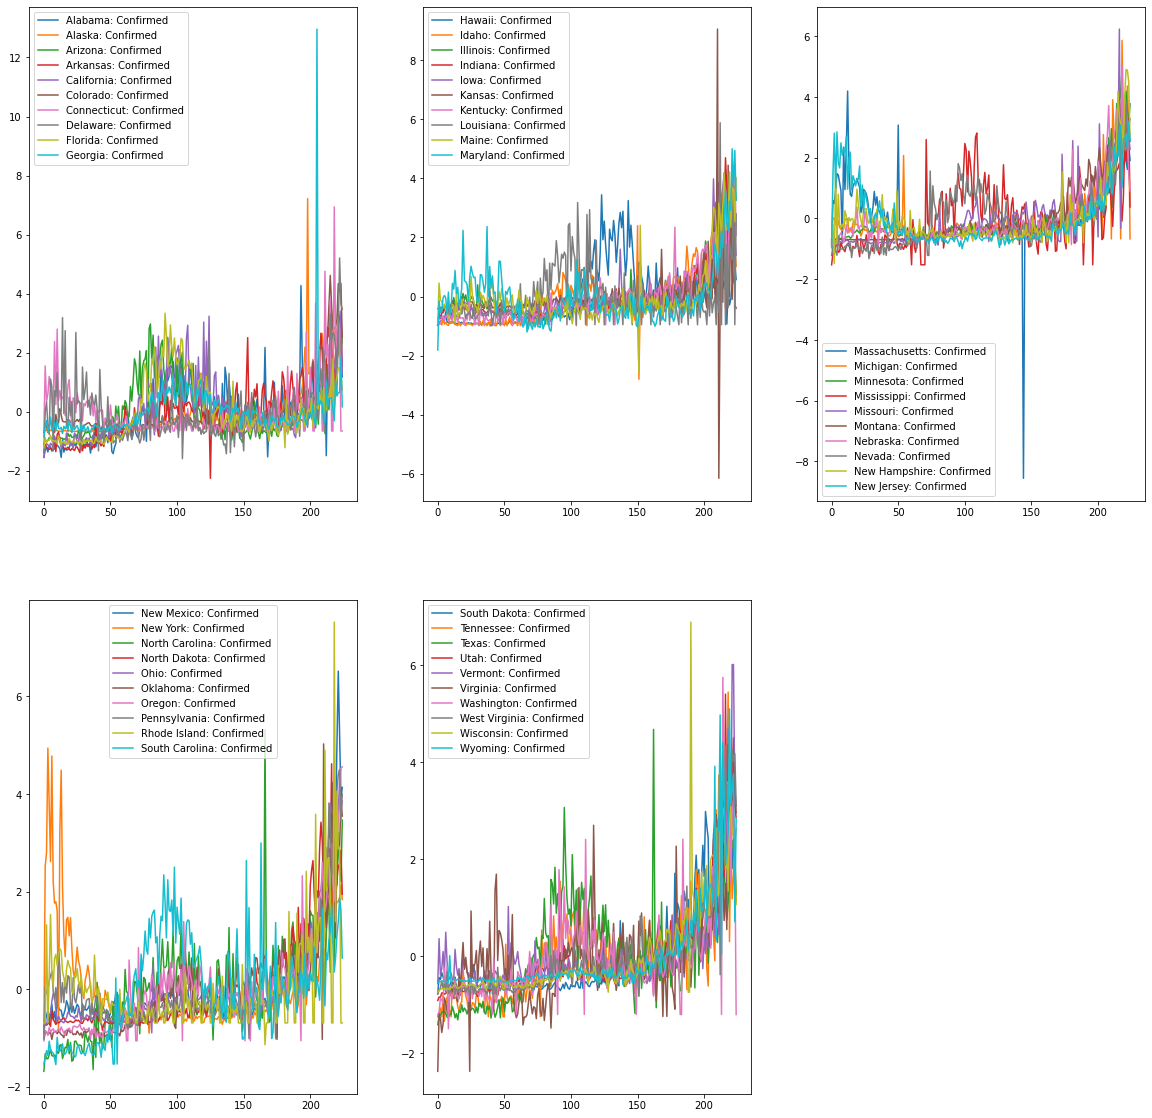

In [187]:
state_count = 1
figure_count = 1
plt.figure(figsize=(20, 20))
for state, confirmed in state_temporal_data.items():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(confirmed, label=f"{state}: Confirmed")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1

### 1.3.2 Plot Daily Cumulative Cases Trend

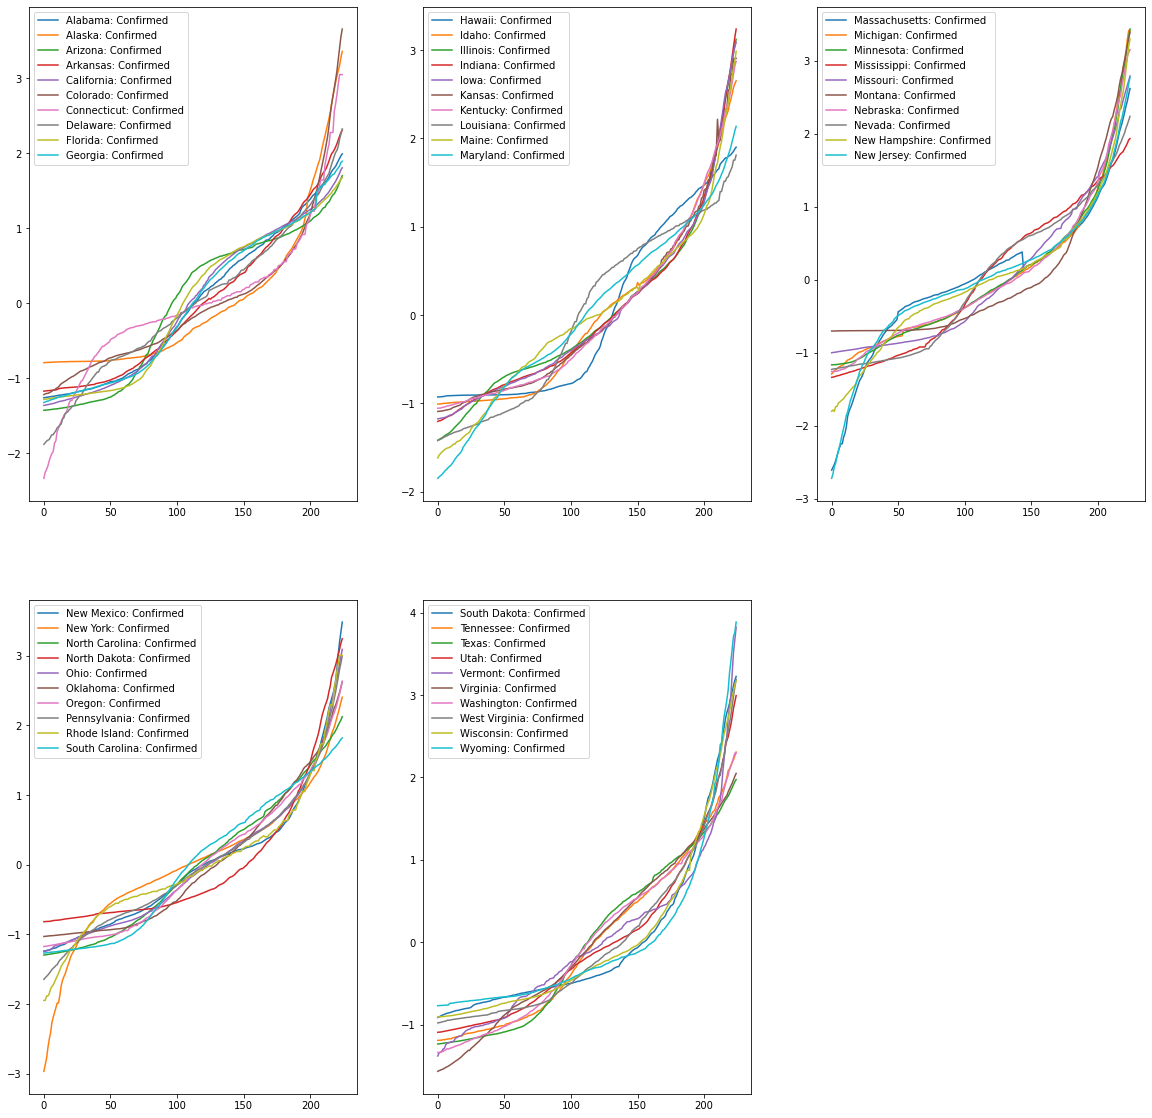

In [197]:
state_count = 1
figure_count = 1
plt.figure(figsize=(20, 20))
for state, confirmed in state_cum_temporal_data.items():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(confirmed, label=f"{state}: Confirmed")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1

### 1.3.3 Plot Daily Difference in Mobility Trend

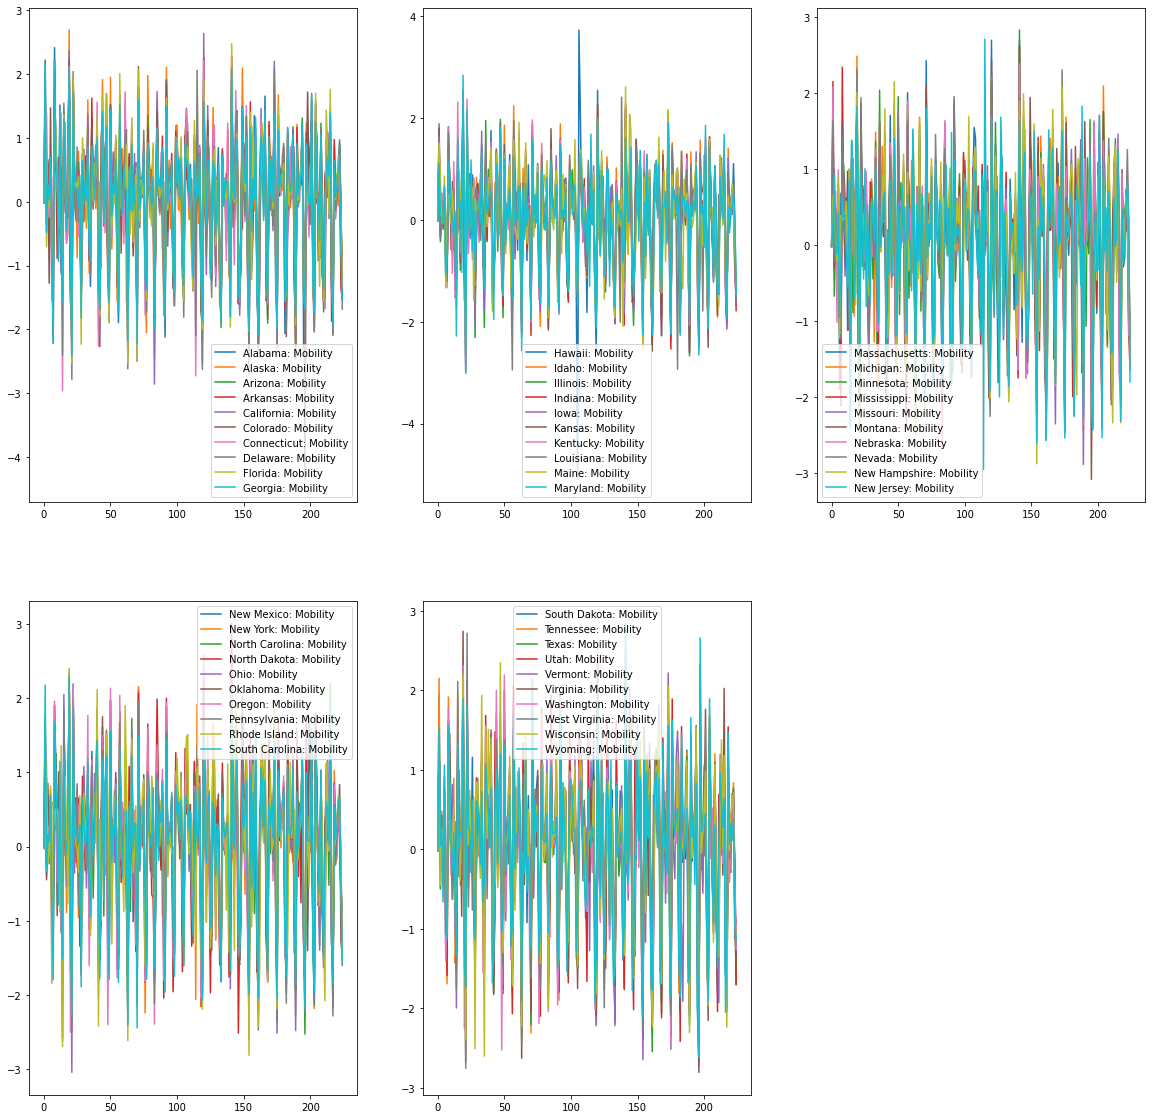

In [188]:
state_count = 1
figure_count = 1
plt.figure(figsize=(20, 20))
for state, mobility in state_mobility_data.items():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(mobility, label=f"{state}: Mobility")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1

## 1.4 Create Cross-validation Datasets

In [79]:
seq_len = 20

def np_array():
    return np.array([])

state_temporal_train = defaultdict(list)
state_mobility_train = defaultdict(list)
state_temporal_res_train = defaultdict(list)
state_mobility_res_train = defaultdict(list)

state_temporal_valid = {}
state_mobility_valid = {}
state_confirmed_valid = {}


for s in state_temporal_data.keys():
    for i in range(state_temporal_data['California'].shape[0] - seq_len):
        state_temporal_train[s].append(np.array(state_temporal_data[s][i:i + seq_len]))
        state_mobility_train[s].append(np.array(state_mobility_data[s][i:i + seq_len]))
        state_temporal_res_train[s].append(np.array(state_temporal_data[s].loc[i + seq_len]))
        state_mobility_res_train[s].append(np.array(state_mobility_data[s].loc[i + seq_len]))
    state_temporal_train[s] = np.array(state_temporal_train[s])
    state_mobility_train[s] = np.array(state_mobility_train[s])
    state_temporal_res_train[s] = np.array(state_temporal_res_train[s])
    state_mobility_res_train[s] = np.array(state_mobility_res_train[s])
        
print(state_temporal_train['California'][0].shape)
print(state_temporal_train['California'][0])
print(state_mobility_train['California'][0].shape)
print(state_mobility_train['California'][0])
print(state_temporal_res_train['California'][0])
print(state_mobility_res_train['California'][0])

(20, 2)
[[-1.53125919 -1.65599101]
 [-1.1727546  -0.13148309]
 [-1.08155053 -0.56411371]
 [-1.11153111  0.25994463]
 [-1.21851443  0.321749  ]
 [-1.06419336  0.01272712]
 [-1.11026877  0.46595921]
 [-1.23460927 -0.89373705]
 [-0.81961497 -0.66712101]
 [-0.96983344 -0.48170788]
 [-0.93827494  1.20761172]
 [-0.8316072   0.65137234]
 [-0.96509966  0.15693733]
 [-1.21157156 -0.25509184]
 [-1.15571301 -0.91433851]
 [-1.08691548 -0.54351226]
 [-1.15318833  0.09513296]
 [-0.71610308  0.03332858]
 [-1.0948051   0.09513296]
 [-0.93290999  0.30114754]]
(20, 1)
[[-0.02152649]
 [ 1.85575697]
 [ 0.05222034]
 [ 0.22918864]
 [-0.08337501]
 [ 0.50661976]
 [-1.05352017]
 [-1.12087928]
 [ 1.74454749]
 [ 0.96733995]
 [ 0.23975451]
 [-0.05279558]
 [ 0.40639129]
 [-1.03880295]
 [-1.34698089]
 [ 1.34352648]
 [ 0.14416619]
 [-0.22367076]
 [ 0.14138746]
 [ 2.36581135]]
[-1.11437138 -0.54351226]
[-1.4571927]


# 2. Building the RNN Model with LSTM

## 2.1 Import Dependencies

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.models import Model

## 2.2 Initialize Model

In [84]:
temporal_input_layer = Input(shape=(seq_len, 2), name='temporal_input')
temporal_rnn_layer = LSTM(30, return_sequences=True, recurrent_dropout=0.2, activation=layers.ReLU(), name='temporal_rnn')(temporal_input_layer)
temporal_second_rnn_layer = LSTM(60, return_sequences=False, recurrent_dropout=0.2, activation=layers.ReLU(), name='temporal_second_rnn')(temporal_rnn_layer)

mobility_input_layer = Input(shape=(seq_len, 1), name='mobility_input')
mobility_rnn_layer = LSTM(30, return_sequences=True, recurrent_dropout=0.2, activation=layers.ReLU(), name='mobility_rnn')(mobility_input_layer)
mobility_second_rnn_layer = LSTM(60, return_sequences=False, recurrent_dropout=0.2, activation=layers.ReLU(), name='mobility_second_rnn')(mobility_rnn_layer)

temporal_concat_layer = Concatenate(axis=-1, name='temporal_concat')([temporal_second_rnn_layer, mobility_second_rnn_layer])
temporal_dense_layer = Dense(units=20, activation=layers.ReLU(), name='temporal_dense')(temporal_concat_layer)
temporal = Dense(2, activation=layers.LeakyReLU(alpha=0.1), name='temporal')(temporal_dense_layer)

mobility_concat_layer = Concatenate(axis=-1, name='mobility_concat')([temporal_second_rnn_layer, mobility_second_rnn_layer])
mobility_dense_layer = Dense(units=20, activation=layers.ReLU(), name='mobility_dense')(mobility_concat_layer)
mobility = Dense(1, activation=layers.LeakyReLU(alpha=0.1), name='mobility')(mobility_dense_layer)

# merged_layer = Concatenate(axis=-1, name='concatenate')([temporal_second_rnn_layer, mobility_second_rnn_layer])
# # merged_rnn_layer = LSTM(10, return_sequences=False, recurrent_dropout=0.2, name='merged_rnn')(merged_layer)
# # merged_second_rnn_layer = LSTM(10, return_sequences=False, recurrent_dropout=0.2, name='merged_second_rnn')(merged_rnn_layer)
# merged_dense_layer = Dense(units=10, name='merged_dense')(merged_layer)
# # merged_dropout_layer = Dropout(0.3, name='merged_dropout')(merged_dense_layer)
# confirmed = Dense(1, activation=layers.LeakyReLU(alpha=0.1), name='confirmed')(merged_dense_layer)

model = Model([temporal_input_layer, mobility_input_layer], [temporal, mobility], name='COVID_pred')

model.summary()

Model: "COVID_pred"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
temporal_input (InputLayer)     [(None, 20, 2)]      0                                            
__________________________________________________________________________________________________
mobility_input (InputLayer)     [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
temporal_rnn (LSTM)             (None, 20, 30)       3960        temporal_input[0][0]             
__________________________________________________________________________________________________
mobility_rnn (LSTM)             (None, 20, 30)       3840        mobility_input[0][0]             
_________________________________________________________________________________________

## 2.3 Train Model

In [88]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([state_temporal_train['California'], state_mobility_train['California']], 
          [state_temporal_res_train['California'], state_mobility_res_train['California']], 
          epochs=1000, batch_size=250, verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 985us/step - loss: 0.3666 - temporal_loss: 0.1626 - mobility_loss: 0.2040
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4141 - temporal_loss: 0.1453 - mobility_loss: 0.2688
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3668 - temporal_loss: 0.1596 - mobility_loss: 0.2072
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3585 - temporal_loss: 0.1454 - mobility_loss: 0.2132
Epoch 5/1000
1/1 [==============================] - 0s 829us/step - loss: 0.3120 - temporal_loss: 0.1357 - mobility_loss: 0.1763
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3400 - temporal_loss: 0.1430 - mobility_loss: 0.1970
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3526 - temporal_loss: 0.1471 - mobility_loss: 0.2055
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3272 - temporal_loss: 0.1294 - mo

1/1 [==============================] - 0s 980us/step - loss: 0.2300 - temporal_loss: 0.0952 - mobility_loss: 0.1348
Epoch 128/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2206 - temporal_loss: 0.0929 - mobility_loss: 0.1277
Epoch 129/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2363 - temporal_loss: 0.0930 - mobility_loss: 0.1433
Epoch 130/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2046 - temporal_loss: 0.0938 - mobility_loss: 0.1108
Epoch 131/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2048 - temporal_loss: 0.0929 - mobility_loss: 0.1119
Epoch 132/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2098 - temporal_loss: 0.0922 - mobility_loss: 0.1176
Epoch 133/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2118 - temporal_loss: 0.0843 - mobility_loss: 0.1275
Epoch 134/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1979 - temporal_loss: 0.0897 - mob

1/1 [==============================] - 0s 1ms/step - loss: 0.1570 - temporal_loss: 0.0720 - mobility_loss: 0.0849
Epoch 254/1000
1/1 [==============================] - 0s 980us/step - loss: 0.1736 - temporal_loss: 0.0849 - mobility_loss: 0.0887
Epoch 255/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1793 - temporal_loss: 0.0846 - mobility_loss: 0.0948
Epoch 256/1000
1/1 [==============================] - 0s 912us/step - loss: 0.1675 - temporal_loss: 0.0761 - mobility_loss: 0.0915
Epoch 257/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1730 - temporal_loss: 0.0752 - mobility_loss: 0.0978
Epoch 258/1000
1/1 [==============================] - 0s 947us/step - loss: 0.1778 - temporal_loss: 0.0752 - mobility_loss: 0.1026
Epoch 259/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1534 - temporal_loss: 0.0770 - mobility_loss: 0.0764
Epoch 260/1000
1/1 [==============================] - 0s 921us/step - loss: 0.1726 - temporal_loss: 0.0772

1/1 [==============================] - 0s 950us/step - loss: 0.1389 - temporal_loss: 0.0625 - mobility_loss: 0.0764
Epoch 380/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1525 - temporal_loss: 0.0635 - mobility_loss: 0.0890
Epoch 381/1000
1/1 [==============================] - 0s 946us/step - loss: 0.1455 - temporal_loss: 0.0657 - mobility_loss: 0.0798
Epoch 382/1000
1/1 [==============================] - 0s 933us/step - loss: 0.1372 - temporal_loss: 0.0584 - mobility_loss: 0.0788
Epoch 383/1000
1/1 [==============================] - 0s 928us/step - loss: 0.1332 - temporal_loss: 0.0680 - mobility_loss: 0.0652
Epoch 384/1000
1/1 [==============================] - 0s 999us/step - loss: 0.1458 - temporal_loss: 0.0684 - mobility_loss: 0.0773
Epoch 385/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1287 - temporal_loss: 0.0633 - mobility_loss: 0.0654
Epoch 386/1000
1/1 [==============================] - 0s 955us/step - loss: 0.1414 - temporal_loss: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.1312 - temporal_loss: 0.0637 - mobility_loss: 0.0675
Epoch 506/1000
1/1 [==============================] - 0s 996us/step - loss: 0.1227 - temporal_loss: 0.0616 - mobility_loss: 0.0612
Epoch 507/1000
1/1 [==============================] - 0s 936us/step - loss: 0.1198 - temporal_loss: 0.0589 - mobility_loss: 0.0609
Epoch 508/1000
1/1 [==============================] - 0s 995us/step - loss: 0.1187 - temporal_loss: 0.0582 - mobility_loss: 0.0604
Epoch 509/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1141 - temporal_loss: 0.0574 - mobility_loss: 0.0566
Epoch 510/1000
1/1 [==============================] - 0s 998us/step - loss: 0.1219 - temporal_loss: 0.0563 - mobility_loss: 0.0656
Epoch 511/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1250 - temporal_loss: 0.0602 - mobility_loss: 0.0648
Epoch 512/1000
1/1 [==============================] - 0s 990us/step - loss: 0.1160 - temporal_loss: 0.06

1/1 [==============================] - 0s 1ms/step - loss: 0.1101 - temporal_loss: 0.0513 - mobility_loss: 0.0587
Epoch 632/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - temporal_loss: 0.0509 - mobility_loss: 0.0501
Epoch 633/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0987 - temporal_loss: 0.0492 - mobility_loss: 0.0495
Epoch 634/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - temporal_loss: 0.0547 - mobility_loss: 0.0472
Epoch 635/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1139 - temporal_loss: 0.0510 - mobility_loss: 0.0629
Epoch 636/1000
1/1 [==============================] - 0s 948us/step - loss: 0.1106 - temporal_loss: 0.0547 - mobility_loss: 0.0560
Epoch 637/1000
1/1 [==============================] - 0s 991us/step - loss: 0.1219 - temporal_loss: 0.0497 - mobility_loss: 0.0722
Epoch 638/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1062 - temporal_loss: 0.0613 - m

1/1 [==============================] - 0s 1ms/step - loss: 0.0922 - temporal_loss: 0.0469 - mobility_loss: 0.0453
Epoch 758/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0956 - temporal_loss: 0.0472 - mobility_loss: 0.0484
Epoch 759/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - temporal_loss: 0.0493 - mobility_loss: 0.0517
Epoch 760/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0971 - temporal_loss: 0.0473 - mobility_loss: 0.0499
Epoch 761/1000
1/1 [==============================] - 0s 948us/step - loss: 0.0981 - temporal_loss: 0.0479 - mobility_loss: 0.0502
Epoch 762/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1025 - temporal_loss: 0.0493 - mobility_loss: 0.0531
Epoch 763/1000
1/1 [==============================] - 0s 974us/step - loss: 0.0868 - temporal_loss: 0.0439 - mobility_loss: 0.0429
Epoch 764/1000
1/1 [==============================] - 0s 945us/step - loss: 0.0974 - temporal_loss: 0.0453 -

1/1 [==============================] - 0s 1ms/step - loss: 0.0832 - temporal_loss: 0.0418 - mobility_loss: 0.0414
Epoch 884/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0830 - temporal_loss: 0.0415 - mobility_loss: 0.0415
Epoch 885/1000
1/1 [==============================] - 0s 918us/step - loss: 0.0820 - temporal_loss: 0.0397 - mobility_loss: 0.0422
Epoch 886/1000
1/1 [==============================] - 0s 963us/step - loss: 0.0851 - temporal_loss: 0.0450 - mobility_loss: 0.0401
Epoch 887/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0857 - temporal_loss: 0.0455 - mobility_loss: 0.0401
Epoch 888/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0844 - temporal_loss: 0.0440 - mobility_loss: 0.0404
Epoch 889/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0811 - temporal_loss: 0.0429 - mobility_loss: 0.0382
Epoch 890/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0804 - temporal_loss: 0.0423 - m

## 2.4 Test Model

In [113]:
forecast_days = 7

temporal_window = np.array(state_temporal_data['California'].tail(seq_len + forecast_days))
mobility_window = np.array(state_mobility_data['California'].tail(seq_len + forecast_days))

print(temporal_window[20:])
print(mobility_window[20:])

[[ 1.49677907 -1.12035309]
 [ 1.81236409 -0.44050496]
 [ 2.17844271  0.52776359]
 [ 2.61363445  0.17753879]
 [ 2.43753801  0.36295192]
 [ 3.41869183 -0.99674434]
 [ 1.33709305 -0.54351226]]
[[ 0.44821955]
 [-0.17984717]
 [ 0.14355687]
 [ 0.19159878]
 [ 0.89166475]
 [-0.42367239]
 [-1.20464293]]


In [136]:
state_temporal_test = np.array(temporal_window[:20])
state_mobility_test = np.array(mobility_window[:20])

temporal_prediction_queue = state_temporal_test.reshape(1, state_temporal_test.shape[0], 2)
mobility_prediction_queue = state_mobility_test.reshape(1, state_mobility_test.shape[0], 1)

for i in range(forecast_days):
    temporal, mobility = model.predict([temporal_prediction_queue, mobility_prediction_queue])

    temporal_prediction_queue = np.append(temporal_prediction_queue[0], temporal[0])
    temporal_prediction_queue = np.delete(temporal_prediction_queue, 0)
    temporal_prediction_queue = np.delete(temporal_prediction_queue, 0)
    temporal_prediction_queue = temporal_prediction_queue.reshape(1, 20, 2)
    
    mobility_prediction_queue = np.append(mobility_prediction_queue, mobility)
    mobility_prediction_queue = np.delete(mobility_prediction_queue, 0)
    mobility_prediction_queue = mobility_prediction_queue.reshape(1, mobility_prediction_queue.shape[0], 1)
    
# prediction_queue
print(temporal_prediction_queue[0][13:])
print(mobility_prediction_queue[0][13:])

[[ 1.53495014 -1.01981044]
 [ 1.76694715 -0.29108793]
 [ 2.23877215  0.56555885]
 [ 2.34095216 -0.04412038]
 [ 2.42017984 -0.02346691]
 [ 3.28425884 -0.35356101]
 [ 1.67334235 -0.8166523 ]]
[[ 0.45758885]
 [-0.04999468]
 [-0.00172194]
 [-0.00195911]
 [ 0.83797741]
 [-0.38126379]
 [-1.03096747]]
